<a href="https://colab.research.google.com/github/luciaschmidtsantiago/probai-2025/blob/main/ProbAI_ChiRho_Tutorial_I_Probabilistic_Programming_%26_Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chirho pyro-ppl torch matplotlib pandas seaborn graphviz

In [3]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns
import torch
from pyro.distributions import Bernoulli, Beta, Normal
from pyro.infer import SVI
from pyro.infer.autoguide import AutoNormal
from pyro.ops.indexing import Vindex
from pyro.poutine import block

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

warnings.filterwarnings("ignore")

smoke_test = "CI" in os.environ

Despite the tremendous progress over the last several decades in reducing causal inference to statistical practice, the \"causal revolution\" proclaimed by causal inference researchers remains incomplete, with a fragmented literature inaccessible to non-experts and still somewhat isolated from cutting-edge machine learning research and software tools.

Probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models.

In this tutorial, we elaborate on this idea with three key observations inspiring ChiRho's design, and outline a causal Bayesian workflow for using ChiRho to answer causal questions.

## Outline
- [Introduction](#causal-probabilistic-programming-without-tears)
- [Outline](#outline)
- [Observation 1: Causal Models are Probabilistic Programs](#observation-1:-causal-models-are-probabilistic-programs)
    - [Defining a Causal Model](#defining-a-causal-model)
    - [Simulating Observational Data](#simulating-observational-data-with-fixed-parameters)
    - [Applying an Intervention](#applying-an-intervention)
    - [Simulating Interventional Data](#simulating-interventional-data-with-fixed-parameters)
    - [Transforming Causal Models using ChiRho](#transforming-causal-models-using-ChiRho---do)
- [Observation 2: Causal Uncertainty is Probabilistic Uncertainty](#observation-2:-causal-uncertainty-is-probabilistic-uncertainty)
    - [Adding Uncertainty over Model Parameters](#adding-uncertainty-over-model-parameters)
    - [Simulating Observational Data with Uncertain Parameters](#simulating-observational-data-with-uncertain-parameters)
    - [Simulating Interventional Data with Uncertain Parameters](#simulating-interventional-data-with-uncertain-parameters)
    - [Adding Uncertainty over Model Structure](#adding-uncertainty-over-model-structure)
    - [Simulating Observational Data with Uncertain Structure and Parameters](#simulating-observational-data-with-uncertain-structure-and-parameters)
    - [Simulating Interventional Data with Uncertain Structure and Parameters](#simulating-interventional-data-with-uncertain-structure-and-parameters)
- [Observation 3: Causal Inference is Probabilistic Inference](#observation-3:-causal-inference-is-probabilistic-inference)
    - [Automatically Constructing Counterfactual Worlds](#automatically-constructing-counterfactual-worlds---twinworldcounterfactual)
    - [Generating Synthetic Data](#generating-synthetic-data)
    - [Conditioning the Causal Model on Observational Data](#conditioning-the-causal-model-on-observational-data)
    - [Using Variational Inference for Bayesian Causal Inference](#using-variational-inference-for-bayesian-causal-inference)
    - [Simulating Interventional Data from the Approximate Posterior](#simulating-interventional-data-from-the-approximate-posterior)
- [Recap](#recap)
- [Causal Bayesian Workflow](#a-causal-bayesian-workflow)
- [References](#references)

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a probability distribution over a set of variables, but programs often contain more information than just the joint distributions they induce. In practice, when we write probabilistic programs in languages such as Pyro we often bring to bear knowledge of causal relationships between variables, and implicitly, how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability distributions, indexed by a set of *interventions*. This set always includes a trivial *identity intervention*, which maps to the usual (acausal) joint distribution over random variables induced by simply executing the program. However, for other interventions the resulting joint distributions can differ significantly, as we'll see later throughout this tutorial.

Somewhat less formally, causal models using these (nontrivial) interventions are useful when we want to represent hypothetical changes to a domain, such as a policy that encourages people to stop smoking. To ground this out a bit more concretely, consider the following Pyro program describing a causal model relating three random variables, *stress*, *smokes*, and *cancer*.

**Note:** Later we'll see how to think of interventions as program transformations. ChiRho defaults to the trivial *identity intervention* if none are applied explicitly. The result of applying this identity intervention to a causal model is sometimes called an *observational model* or *factual model*.

### Defining a Causal Model

In [4]:
def causal_model(stress_prob, smokes_cond_prob, cancer_cond_prob):
    stress = pyro.sample("stress", Bernoulli(stress_prob))

    # Vindex is a helper function that allows for broadcastable indexing into a tensor
    smokes_prob = Vindex(smokes_cond_prob)[..., stress.int()]
    smokes = pyro.sample("smokes", Bernoulli(smokes_prob))

    cancer_prob = Vindex(cancer_cond_prob)[..., stress.int(), smokes.int()]
    cancer = pyro.sample("cancer", Bernoulli(cancer_prob))

    return {"stress": stress, "smokes": smokes, "cancer": cancer}

Our `causal_model` takes as input three sets of parameters: marginal and conditional probability tables over *stress*, *smokes*, and *cancer* attributes;

1.   `stress_prob`: a tensor representing the probability that someone is stressed,
2.   `smokes_cond_prob`: a tensor representing the conditional probability of whether someone smokes given that they are stressed (or not),
3.    `cancer_cond_prob`: a tensor representing the conditional probability of whether someone gets cancer given that they are stressed (or not) and whether they smoke (or not).

The `causal_model` returns a sample from the joint distribution over whether the *stres*, *smokes*, and *cancer* attributes.

For now, let's just choose some parameters by hand, but later we'll see how we can place priors over these parameters to express broader uncertainty and enable Bayesian causal inference.

#### Note: `Vindex`

Pyro and Chirho use tensor dimensions to encode a variety of things, so the tensors in your models will have leading dimensions that you need to be careful to preserve. If we just indexed into e.g. `smokes_cond_prob` like this `smokes_cond_prob[stress.int()]`, we would sometimes access the wrong tensor dimension. Instead, we use `pyro.ops.indexing.Vindex`, which hides some of this complexity from us, but still requires us to access our tensor dimensions from the right, preserving any additional leading dimensions.

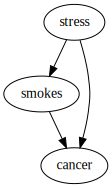

In [5]:
stress_prob = torch.tensor(0.5)
smokes_cond_prob = torch.tensor([0.2, 0.8]) #not stressed vs stressed
cancer_cond_prob = torch.tensor([[0.1, 0.15],[0.8, 0.85]]) # non-stressed vs stress vs non smoker vs smoker

pyro.render_model(causal_model, (stress_prob, smokes_cond_prob, cancer_cond_prob))

In [6]:
cancer_cond_prob # [non-smkr_non-stss VS non-smkr_stss], [smkr_non-stss VS smkr_stss]

tensor([[0.1000, 0.1500],
        [0.8000, 0.8500]])

### Problem 1:

There are many other possible covariates we could consider. For example, smoking behavior, stress, and cancer risk could be affected by age, gender, or income level.

*Modify the causal model above to consider age as an additional covariate.*

 Assume that age only affects stress and cancer risk (although in the real world, it could also affect smoking prevalence). We'll also make the simplifying assumption that stress and cancer risk increase with age.

More precisely, assume that:
- $\mathit{age} \sim \mathcal{N}(45, 15)$
- The probability of being stressed increases with age, or $\text{logit}(P(\mathit{stress}|\mathit{age})) = s_0 + s_1*(\mathit{age} - 45)$.
- The effect of age on cancer risk is modeled by an additional log-odds factor of $c * (\mathit{age} - 45)$.

Rendering the model with `pyro.render_model` should reveal the new covariate.

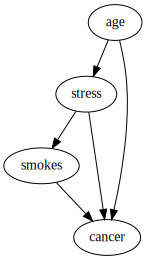

In [7]:
stress_age_intercept = torch.tensor(-5)
stress_age_linear = torch.tensor(0.1) # Assume that stress increases with age
age_cancer_coeff = torch.tensor(0.02) # Assume a 2%/year increase in risk

def causal_model_with_age(smokes_cond_prob, cancer_cond_prob, stress_age_intercept, stress_age_linear, age_cancer_coeff):
    age = pyro.sample("age", Normal(45, 15))

    stress_logit = stress_age_intercept + stress_age_linear * (age - 45)
    stress = pyro.sample("stress", Bernoulli(logits=stress_logit))

    # Vindex is a helper function that allows for broadcastable indexing into a tensor
    smokes_prob = Vindex(smokes_cond_prob)[..., stress.int()]
    smokes = pyro.sample("smokes", Bernoulli(smokes_prob))

    age_cancer_logit = age_cancer_coeff * (age - 45)
    age_cancer_prob = torch.sigmoid(age_cancer_logit)

    cancer_stress_smoke_prob = Vindex(cancer_cond_prob)[..., stress.int(), smokes.int()]

    cancer = pyro.sample("cancer", Bernoulli(age_cancer_prob * cancer_stress_smoke_prob))


    return {"age": age, "stress": stress, "smokes": smokes, "cancer": cancer}


causal_model_with_age_params = (smokes_cond_prob, cancer_cond_prob, stress_age_intercept, stress_age_linear, age_cancer_coeff)
causal_model_with_age(*causal_model_with_age_params)

pyro.render_model(causal_model_with_age, causal_model_with_age_params)

### Simulating Observational Data with Fixed Parameters

Fortunately, all causal models written in ChiRho compose freely with the probabilistic programming tooling in Pyro. In summary, Pyro provides support for probabilistic modeling and inference with a set of composable *effect handlers*, which can be thought of as context managers that change how pyro primitive operations (such as `pyro.sample`) are interpreted. For more background on Pyro and its use of effect handlers, see https://pyro.ai/examples/intro_long.html and https://pyro.ai/examples/effect_handlers.html. Perhaps not surprisingly, ChiRho's main capabilities also make heavy use of similar effect handlers.

As an example, let's use Pyro's `plate` effect handler to repeatedly sample from the `causal_model` to approximate the joint distribution for all of the attributes.

In [8]:
n_individuals = 10000 if not smoke_test else 10

def population_causal_model(n_individuals, model, *model_params):
    with pyro.plate("individuals", n_individuals, dim=-1):
        return model(*model_params)

result = population_causal_model(
    n_individuals, causal_model, stress_prob, smokes_cond_prob, cancer_cond_prob
)

print("smokes.shape ---", result["smokes"].shape)

smokes.shape --- torch.Size([10000])


Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke and how likely they are to get cancer. To understand this relationship a bit better, we can simulate observations from our model.

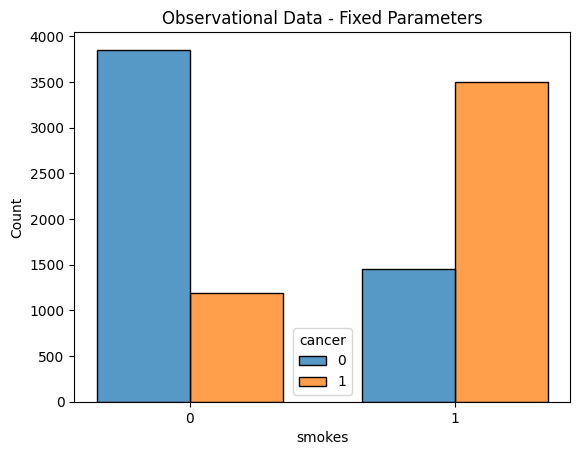

In [9]:
num_samples = 5000 if not smoke_test else 10


def visualize_proportions_single(prediction, title):
    cancer = prediction["cancer"]
    smokes = torch.broadcast_tensors(prediction["smokes"], prediction["cancer"])[0]

    assert cancer.shape == smokes.shape

    data = torch.concat((smokes.reshape(-1, 1), cancer.reshape(-1, 1)), axis=-1)
    frame = (
        pd.DataFrame(data.numpy(), columns=["smokes", "cancer"])
        .astype("category")
        .replace({0: "0", 1: "1"})
    )

    sns.histplot(
        x="smokes", hue="cancer", multiple="dodge", shrink=0.7, data=frame
    ).set(title=title)


prediction_fixed = population_causal_model(
    n_individuals, causal_model, stress_prob, smokes_cond_prob, cancer_cond_prob
)

plot = visualize_proportions_single(
    prediction_fixed, "Observational Data - Fixed Parameters"
)

As we can see clearly from this simulation, individuals who smoke are much more likely to get cancer than individuals who don't. Of the ~5,000 simulated individuals who smoke ~3600 got cancer, roughly 72% of the smokers. Of the remaining ~5,000 simulated individuals who did not smoke only ~1,200 individuals got cancer, a much lower 24% of the smoking population.

We can also approximate our uncertainty in this conclusion by repeating the process a number of times, each time calculating the proportions of individuals with cancer for smokers and non-smokers.

<Axes: title={'center': 'Observational Data - Fixed Parameters'}, xlabel='Proportion of Individuals w/ Cancer', ylabel='Density'>

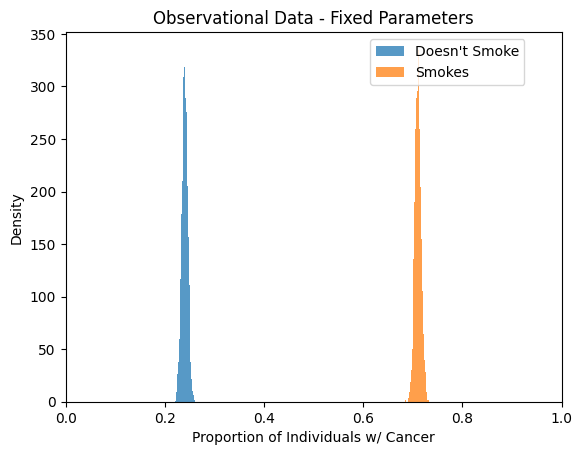

In [10]:
def multiple_samples(model, args, num_samples=num_samples):
    with pyro.plate("samples", num_samples, dim=-2):
        return model(*args)

def visualize_proportions_multiple(prediction, title, position=(0.6, 1), ax=None):
    cancer = prediction["cancer"]
    smokes = torch.broadcast_tensors(prediction["smokes"], cancer)[0]

    assert cancer.shape == smokes.shape

    cancer_and_smokes = cancer * smokes
    cancer_given_smokes = cancer_and_smokes.sum(1) / smokes.sum(1)
    cancer_and_not_smokes = cancer * (1 - smokes)
    cancer_given_not_smokes = cancer_and_not_smokes.sum(1) / (1 - smokes).sum(1)

    if ax is None:
        ax = plt.gca()
    sns.histplot(
        data=cancer_given_not_smokes.detach().numpy(),
        label="Doesn't Smoke",
        ax=ax,
        legend=True,
        ec=None
    )
    sns.histplot(
        data=cancer_given_smokes.detach().numpy(), label="Smokes", ax=ax, legend=True, ec=None
    )
    ax.legend(loc="upper left", bbox_to_anchor=position)
    ax.set(
        xlabel="Proportion of Individuals w/ Cancer",
        ylabel="Density",
        title=title,
        xlim=(0, 1),
    )
    return ax

predictions_fixed = multiple_samples(
    population_causal_model,
    (n_individuals, causal_model, stress_prob, smokes_cond_prob, cancer_cond_prob),
)

visualize_proportions_multiple(
    predictions_fixed, "Observational Data - Fixed Parameters"
)

As we can see clearly, even when simulating many times our model tells us that individuals who smoke are consistently much more likely to get cancer than individuals who don't. In fact, since our model together with the chosen probability tables describe a unique joint distribution over individual attributes, we're only approximating an answer that we could've straightforwardly obtained by hand. Let  $c, s, t$ stand for the presence of cancer, smoking and stress, respectively. $P(t \vert s) = \frac{P(s\vert t)P(t)}{P(s)}= .8$, and $P(t\vert \neg s ) = \frac{P(\neg s \vert t)P(t)}{P(\neg s)} = .2$. Then, $P(c\vert s) = P(c\vert t, s ) \times P(t \vert  s) + P(c\vert t, s) \times P(\neg t\vert s) =.71$, and analogously $P(c\vert \neg s) = .24$, which are modes of the empirical distributions shown above. The variance here is only due to the fact that we are simulating a finite population.

### Problem 2:

*Modify the plotting code above to visualize the proportion of the population that has cancer by age.*

You should see that cancer rates increase with age.

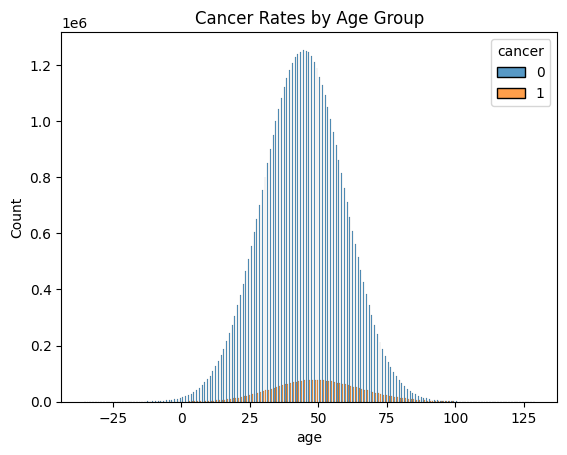

In [11]:
def plot_cancer_by_age(prediction, title="Cancer Rates by Age Group"):
    """
    Simple bar plot of cancer rates by age bins
    """
    cancer = prediction["cancer"]
    age = torch.broadcast_tensors(prediction["age"], prediction["cancer"])[0]
    assert cancer.shape == age.shape

    data = torch.concat((age.reshape(-1, 1), cancer.reshape(-1, 1)), axis=-1)
    frame = (
        pd.DataFrame(data.numpy(), columns=["age", "cancer"])
        .astype("category")
        .replace({0: "0", 1: "1"})
    )
    sns.histplot(
        x="age", hue="cancer", multiple="dodge", shrink=0.7, data=frame
    ).set(title=title)

predictions_fixed = multiple_samples(
    population_causal_model,
    (n_individuals, causal_model_with_age) + causal_model_with_age_params,
)

_ = plot_cancer_by_age(predictions_fixed)

So far we have a program that describes the distribution over data given model parameters. Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space" induces a joint distribution over data.

![fig1](https://basisresearch.github.io/chirho/_images/Conditional_Distribution_of_Data.png)

### Applying an Intervention

Simulating from our `causal_model` is certainly interesting and informative, but it doesn't exactly tell us what we're interested in. We want to know to what extent smoking *causes* cancer, not just whether smoking is associated with cancer. To answer this question, we can instead sample from a modified version of our model in which individuals are forced to smoke or not smoke, regardless of their level of stress. We can represent these kinds of modifications as **interventions**, and implement them in ChiRho as a special kind of program transformation. Later we'll see how ChiRho helps to automate the application of these kinds of interventions, but to build some intuition let's first walk through what these new programs would look like if we built them by hand instead.

Consider the following new Pyro program; `intervened_causal_model`, which closely resembles our original `causal_model` except in how the *smokes* attribute is assigned. Specifically, we've added the expression `smokes = smokes_assignment` after ` pyro.sample("smokes", Bernoulli(smokes_prob))`, where `smokes_assignment` is now an argument. This emulates an experimental setting, where instead of letting the upstream factors decide whether a subject smokes, we make such a decision for them. This simple change means that any downstream computation will use `smokes_assignment` rather than the values of `smokes` sampled from the Bernoulli distribution. As we will simplify these models later on, we call these versions `manual`.

In [12]:
def intervened_causal_model_manual(
    stress_prob, smokes_cond_prob, cancer_cond_prob, smokes_assignment
):

    stress = pyro.sample("stress", Bernoulli(stress_prob))

    # smokes_prob = Vindex(smokes_cond_prob)[..., stress.int()]
    # smokes = pyro.sample("smokes", Bernoulli(smokes_prob))
    # smokes no longer depends on stress, as it's just reassigned by `smokes_assignment`.
    smokes = smokes_assignment

    cancer_prob = Vindex(cancer_cond_prob)[..., stress.int(), smokes.int()]
    cancer = pyro.sample("cancer", Bernoulli(cancer_prob))

    return {"stress": stress, "smokes": smokes, "cancer": cancer}


def population_intervened_causal_model_manual(
    n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob
):
    # Imagine that we force half the people to always smoke and half to never smoke.
    smokes_assignment = torch.tensor([0.0, 1.0]).repeat(n_individuals // 2)

    with pyro.plate("individuals", n_individuals, dim=-1):
        return intervened_causal_model_manual(
            stress_prob, smokes_cond_prob, cancer_cond_prob, smokes_assignment
        )

### Simulating Interventional Data with Fixed Parameters

Let's visualize a simulation from these new programs (compare this to the previous visualization based on the original simulation). First, one run on a barplot, then the proportions obtained in multiple (1k) runs using a histogram.

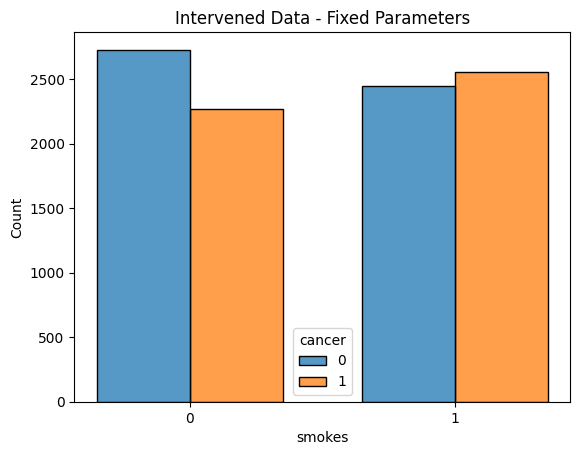

In [13]:
prediction_int_fixed = population_intervened_causal_model_manual(
    n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob
)
_ = visualize_proportions_single(prediction_int_fixed, "Intervened Data - Fixed Parameters")

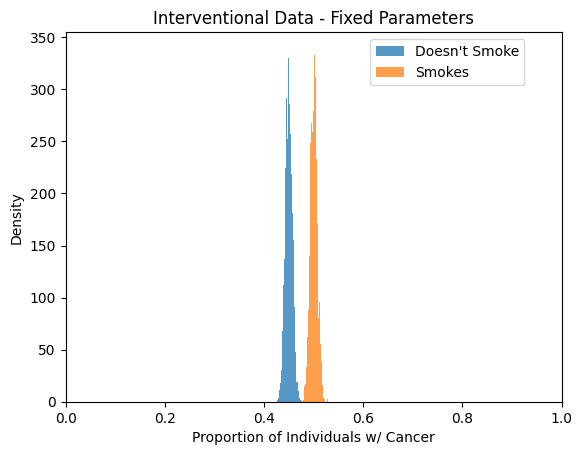

In [14]:
predictions_int_fixed = multiple_samples(
    population_intervened_causal_model_manual,
    (n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob),
)
_ = visualize_proportions_multiple(
    predictions_int_fixed, "Interventional Data - Fixed Parameters"
)

### Problem 3:

The smoking intervention can also be applied to our enhanced model that includes age. Apply the intervention manually to produce a new intervened model, as we did above. Constructing intervened models this way is tedious, and later we will see an automated way to solve this problem.

Rendering the model should show that the causal edge between `smokes` and `cancer` is gone in the intervened model.

In [ ]:
def intervened_causal_model_with_age_manual(
    smokes_cond_prob,
    cancer_cond_prob,
    stress_age_intercept,
    stress_age_linear,
    age_cancer_coeff,
    smokes_assignment
):
    pass # Implement me!

smokes_assignment = torch.tensor([0.0, 1.0]).repeat(n_individuals // 2)
pyro.render_model(intervened_causal_model_with_age_manual, causal_model_with_age_params + (smokes_assignment,))

Using our intervened model we can clearly see that changing the mechanism by which individuals choose whether or not to smoke dramatically changes the joint distribution between smoking and cancer. In our observational model, individuals who smoke are much more likely to get cancer than those who don't smoke. However, in our modified model in which individuals are either forced to smoke or forced not no smoke, the dependence between smoking and cancer nearly disapears.

The phenomenon we're observing in this (contrived) example is known as confounding. Here, the reason we see a statistical dependency between smoking and cancer in our original `causal_model` without any interventions is because of the individuals' stress. Given the parameters we happened to choose, individuals who are stressed are more likely to smoke and stress causes an increase in cancer. The confounding effect of stress disappears in our intervened program, as stress no longer influences whether individuals smoke or not.

In causal inference settings we often wish to answer a specific scientific or policy question using our causal models. For example, we may be interested in the **Average Treatment Effect** (ATE), the average difference in the proportion of individuals with cancer between individuals who were forced to smoke and those who were forced to not smoke. This ATE quantity can be expressed as a function of the population of individuals' attributes after applying an intervention.

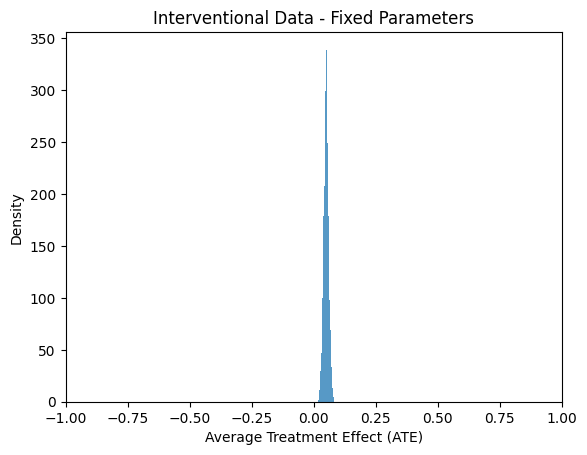

In [ ]:
def visualize_ATE(prediction, title=None, position=(0.6, 1), ax=None, label=None):
    cancer = prediction["cancer"]
    smokes = torch.broadcast_tensors(cancer, prediction["smokes"])[1]

    assert cancer.shape == smokes.shape

    cancer_and_smokes = cancer * smokes
    cancer_given_smokes = cancer_and_smokes.sum(1) / smokes.sum(1)
    cancer_and_not_smokes = cancer * (1 - smokes)
    cancer_given_not_smokes = cancer_and_not_smokes.sum(1) / (1 - smokes).sum(1)

    ate = cancer_given_smokes - cancer_given_not_smokes

    if ax is None:
        ax = plt.gca()

    ax = sns.histplot(data=ate.detach().numpy(), ax=ax, label=label, ec=None)
    ax.set_xlim(-1, 1)
    ax.set(xlabel="Average Treatment Effect (ATE)", ylabel="Density", title=title)
    return ax

_ = visualize_ATE(predictions_int_fixed, "Interventional Data - Fixed Parameters")

**Note:** Just as in the observational setting above, the expectation of the proportion of individuals with cancer in this interventional setting also has a closed-form analytic solution that we can easily compute by hand. This is the case here because (i) the structure of our `causal_model` is isomorphic to a causal graphical model, and thus Pearl's backdoor adjustment formula applies, and (ii) all attributes ($stress$, $smokes$, $cancer$) are discrete. In more complicated examples like our [structured latent confounder](slc.ipynb) example, this will not be the case. Using Pearl's $do$ notation (see Pearl, 2009), we have $P(c\vert do(s)) = P(c\vert s, t)P(t) + P(c\vert s, \neg t) P(\neg t) = 0.5$, and anologously $P(c\vert do(\neg s)) = .45$. Therefore, we have that $ATE \equiv E[P(c\vert do(s))] - E[P(c\vert do(\neq s))] = 0.5 - 0.45 = 0.05$, which is again consistent with our answer simulated answer above.

### Transforming Causal Models using ChiRho - `do`


So far, we've accomplished some limited form of causal reasoning by manually rewriting our original program, replacing the mechanism for how individuals choose to smoke directly in Pyro's syntax, and then simulating from the new programs. In fact, even though we called our program a `causal_model`, we haven't seen anything that we couldn't already do in an ordinary probabilistic programming language like Pyro.

This manual approach is perfectly reasonable in simple scenarios where we have a single model and a single "thought experiment" we want to explore. However, as we'll see throughout these tutorials and examples, reasoning about cause and effect can often involve much more complicated compositions of program transformations. For example, in our [Mediation Analysis](mediation.ipynb) example we'll need to simulate multiple counterfactual models simultaneously, with intervention assignments in one model that depend on simulated outcomes in another.

One of the key insights behind ChiRho (and borrowed from Pearl's structural formalism \[Pearl 2009\]) is that an intervention can be represented as model agnostic program transformation, that is, a function $I: \mathcal{P} \rightarrow \mathcal{P}$, where $\mathcal{P}$ is the space of programs in our language. In ChiRho, and in many formalisms for causal models, we'll assume that models satisfy a kind of locality-preserving property known as autonomy \[Aldrich 1989\]. This autonomy property implies that interventions can be accurately represented as an alteration of a small number of model components, and all other model components (and the causal relationships among them) remain unchanged.

In that vein, ChiRho addresses the complexity of causal reasoning by automating a number of probabilistic program transformations; including interventions, construction of parallel counterfactual worlds, and (as we'll see in subsequent tutorials) automatic reparameterization for counterfactual or "what if" reasoning.

For example, instead of rewriting the code by hand, we can implement our `intervened_causal_model` succinctly as follows using ChiRho's `do` program transformation. As the name implies, this special function `do` operates very similarly to the $do$ operator used with structural causal models and causal graphical models. Here, `do` takes as input a probabilistic program and a dictionary describing the intervention assignment and returns a transformed probabilistic program with the intervention applied.

In [ ]:
def intervened_causal_model(model, smokes_assignment, *model_params):
    transformed_model = do(model, {"smokes": smokes_assignment})
    return transformed_model(*model_params)

Just as with our manual implementation of the `intervened_causal_model`, models constructed using ChiRho's `do` transformation are probabilistic programs in Pyro, and can thus freely compose with all of Pyro's effect handlers. For example, we can again use an `plate` effect handler to sample from a population of individuals by calling our `intervened_causal_model` in the context of a Pyro `plate`.

In [ ]:
def population_intervened_causal_model(model, n_individuals, *model_params):
    # Let's imagine that we force half the people to always smoke and half to never smoke.
    smokes_assignment = torch.tensor([0.0, 1.0]).repeat(n_individuals // 2)

    with pyro.plate("individuals", n_individuals, dim=-1):
        return intervened_causal_model(model, smokes_assignment, *model_params)

forced_smokes_result = population_intervened_causal_model(
    causal_model, n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob
)

### Problem 4:

Use `do` to construct an intervened version of the extended model. Note that because it shares much of the structure with the original model, the amount of code you need to write is very small.

In [ ]:
# Implement me!

To recap, so far we've constructed a causal model describing how data is generated in the actual world we can observe, which we called `causal_model`, and transformed our causal model to represent our thought experiments, or interventions, resulting in the `intervened_causal_model` program. Then, we sampled from our original and transformed models to generate simulated outcomes, and finally summarized the simulated outcomes yielding an answer to our causal query. Again, this process can be viewed somewhat abstractly as follows:

![fig2](https://basisresearch.github.io/chirho/_images/Interventional_Conditional.png)

In this section, we've seen that a probabilistic program specifies a causal model by:
  1. specifying a "default" or "observational" joint distribution over the variables of interest according to the usual semantics of probabilistic programming languages, and
  2. encoding the information  necessary for determining the new joint distribution under an arbitrary intervention (program transformation)---to apply the transformation and derive the new joint distribution.

## Observation 2: causal uncertainty is probabilistic uncertainty

We've shown how to define a causal model as a probabilistic program, and how to use ChiRho's intervention program transformations, `do`, to answer causal questions. However, in doing so we made a few very strong assumptions.

1. We assumed that we knew the **parameters** of our causal model exactly, i.e. we asserted *how much* variables causally affect which other variables.
2. We assumed that we knew the **structure** of our causal model exactly, i.e. we asserted *which* variables causally affect which other variables.

In this section, we'll show how we can use ChiRho to substantially relax these assumptions, representing broad uncertainty over causal structure and parameters. Simply put, we can introduce uncertainty over causal model parameters the same way we would write any other Bayesian hierarchical model, by composing a prior distribution over parameters with our original causal model.

### Adding Uncertainty over Model Parameters

Note how we use the plate structure to meaningfully arrange elements of the model: parameters are effectively sampled outside of the plate, implying that they are shared by the population members, whose features are sampled within the individuals plate. This structure is represented in the model rendering by a box.

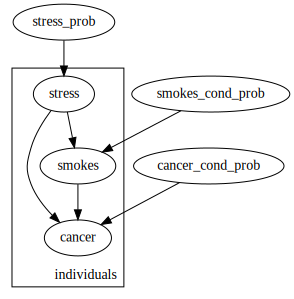

In [ ]:
def parameter_prior():
    # Note: Here `to_event` tells Pyro to treat this distribution
    # as multivariate, rather than multiple samples
    # from a univariate distribution. Omitting this will result in errors,
    # see http://pyro.ai/examples/tensor_shapes.html.

    stress_prob = pyro.sample("stress_prob", Beta(1.0, 1.0))
    smokes_cond_prob = pyro.sample(
        "smokes_cond_prob", Beta(torch.ones(2), torch.ones(2)).to_event(1)
    )
    cancer_cond_prob = pyro.sample(
        "cancer_cond_prob", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)
    )

    return stress_prob, smokes_cond_prob, cancer_cond_prob

def bayesian_population_causal_model(n_individuals):
    stress_prob, smokes_cond_prob, cancer_cond_prob = parameter_prior()
    return population_causal_model(
        n_individuals, causal_model, stress_prob, smokes_cond_prob, cancer_cond_prob
    )

pyro.render_model(bayesian_population_causal_model, (n_individuals,))

### Problem 5:

Write a version of `bayesian_population_causal_model` that includes the `age` covariate. You should be able to reuse parts of `parameter_prior`. Normal distributions are fine priors for the coefficients for this example.

In [ ]:
def parameter_prior_age():
    pass # Implement me!

def bayesian_population_causal_model_age(n_individuals):
    params = parameter_prior_age()
    return population_causal_model(n_individuals, causal_model_with_age, *params)

pyro.render_model(bayesian_population_causal_model_age, (n_individuals,))

TypeError: Value after * must be an iterable, not NoneType

### Simulating Observational Data with Uncertain Parameters

We have now reached a stage where seeing what the observational or an interventional distribution downstream analytically becomes cumbersome (and it is impossible in more complex cases). But again, by sampling multiple times from the model, sampling 'n_individuals' and calculating the proportions of cancer in two groups each time,  we can approximate how our new uncertainty about the parameters propagates to uncertainty about the relationship between smoking and cancer.

<Axes: title={'center': 'Observational Data - Uncertain Parameters'}, xlabel='Proportion of Individuals w/ Cancer', ylabel='Density'>

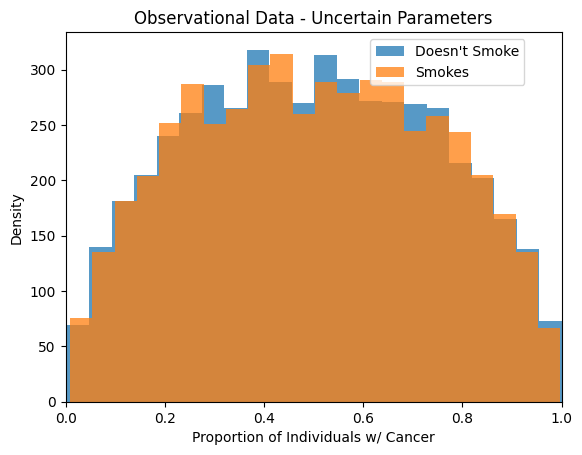

In [ ]:
predictions_bayesian = multiple_samples(
    bayesian_population_causal_model, (n_individuals,)
)

visualize_proportions_multiple(
    predictions_bayesian, "Observational Data - Uncertain Parameters"
)

We see that our uniform uncertainty about the parameters propagates downstream, resulting in broad uncertainty about the observed relationship between smoking and cancer.

### Simulating Interventional Data with Uncertain Parameters

Earlier we showed how to extend the `population_causal_model` to the `bayesian_population_causal_model` by simply sampling from the prior over parameters and then calling `population_causal_model` with the sampled parameters. Perhaps not surprisingly, we can also apply this simple recipe with our `population_intervened_causal_model` to construct a `bayesian_population_intervened_causal_model` which also incorporates uncertainty over parameters.



In [ ]:
def bayesian_population_intervened_causal_model(n_individuals):
    stress_prob, smokes_cond_prob, cancer_cond_prob = parameter_prior()
    return population_intervened_causal_model(
        causal_model, n_individuals, stress_prob, smokes_cond_prob, cancer_cond_prob
    )

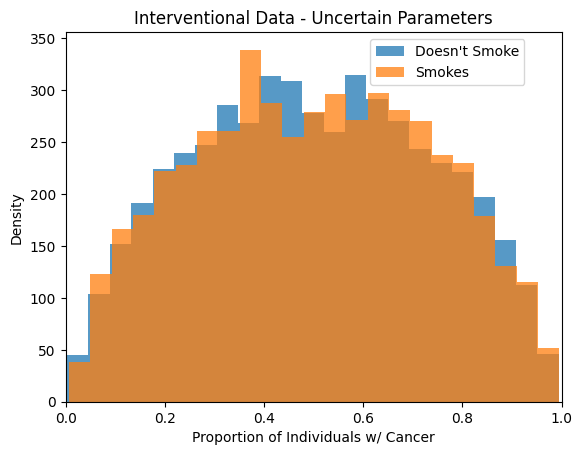

In [ ]:
predictions_int_bayesian = multiple_samples(
    bayesian_population_intervened_causal_model, (n_individuals,)
)
_ = visualize_proportions_multiple(
    predictions_int_bayesian, "Interventional Data - Uncertain Parameters"
)

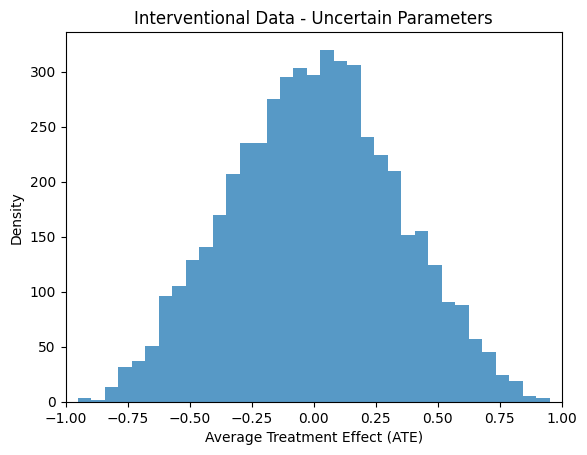

In [ ]:
_ = visualize_ATE(predictions_int_bayesian, "Interventional Data - Uncertain Parameters")

Just as our uncertain parameters propagate to broad uncertainty about the observational relationship between cancer and smoking, we see a similar conclusion when it comes to the effects of the intervention, with ATE estimates centering around 0. However, this is not always the case, as we'll see now when we explore uncertainty over causal structure as well.


**A Brief Aside:** Intervention program transformations can be called both inside and outside of `pyro.plate` contexts, and freely compose with nested probabilistic program function calls. In practice, this means that we can easily; (i) define interventions that are themselves parameterized by random choices, and (ii) apply our intervention to the Bayesian variant of our observational model above without rewriting the model to generate a Bayesian variant of our intervened model with the same prior. As an example, we can succinctly write a variant of this intervention in which treatment assignment is randomized as follows.

In [ ]:
def randomized_intervention(model, intervention_variable, n_individuals):
    def new_model(*args, **kwargs):
        intervention_assignment = pyro.sample(
            "treatment_assignment",
            Bernoulli(torch.ones(n_individuals) * 0.5).to_event(1),
        )
        return do(model, {intervention_variable: intervention_assignment})(
            *args, **kwargs
        )

    return new_model


bayesian_randomized_model = randomized_intervention(
    bayesian_population_causal_model, "smokes", n_individuals
)

### Problem 6:

Visualize the ATE for the extended model with parameter uncertainty.

In [ ]:
# Implement me!

### Adding Uncertainty over Model Structure

In addition to adding prior distributions over model parameters given a known structure, we can further add uncertainty to our causal assumptions by writing a probabilistic program that selects between multiple probabilistic programs depending on the result of a discrete random choice. Again, we'll see how we can quickly expand the complexity of our uncertain causal assumptions without needing to rewrite our original `causal_model` from scratch, as probabilistic programs in ChiRho are compositional.

In the context of our original smoking example, let's pretend that we don't know whether smoking influences cancer, or whether cancer influences smoking. (This might seem somewhat nonsensical now, but it could have been a "plausible" hypothesis 70 years ago.) Graphically, this would be represented as uncertainty about the causal edge between the `smokes` and `cancer` variables. To implement this uncertainty in ChiRho, we first need to write a new program that represents the alternative observational model.

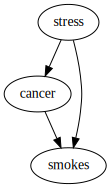

In [ ]:
def alt_causal_model(stress_prob, cancer_cond_prob, smokes_cond_prob):
    stress = pyro.sample("stress", Bernoulli(stress_prob))

    cancer_prob = Vindex(cancer_cond_prob)[..., stress.int()]
    cancer = pyro.sample("cancer", Bernoulli(cancer_prob))

    smokes_prob = Vindex(smokes_cond_prob)[..., stress.int(), cancer.int()]
    smokes = pyro.sample("smokes", Bernoulli(smokes_prob))

    return {"stress": stress, "cancer": cancer, "smokes": smokes}


stress_prob = torch.tensor([0.5])
cancer_cond_prob = torch.tensor([0.2, 0.8])
smokes_cond_prob = torch.tensor([[0.1, 0.15], [0.8, 0.85]])

pyro.render_model(alt_causal_model, (stress_prob, cancer_cond_prob, smokes_cond_prob))

Again, we can  use Pyro's `plate` effect handler to represent a distribution over a population of individuals and place a prior over parameters for this alternative model to represent our uncertainty about the strength of effects.

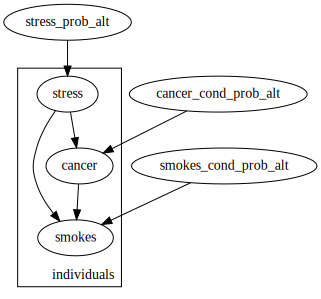

In [ ]:
def alt_population_model(
    n_individuals, stress_prob, cancer_cond_prob, smokes_cond_prob
):
    with pyro.plate("individuals", n_individuals, dim=-1):
        return alt_causal_model(stress_prob, cancer_cond_prob, smokes_cond_prob)


def alt_parameter_prior():

    stress_prob = pyro.sample("stress_prob_alt", Beta(1.0, 1.0))
    cancer_cond_prob = pyro.sample(
        "cancer_cond_prob_alt", Beta(torch.ones(2), torch.ones(2)).to_event(1)
    )
    smokes_cond_prob = pyro.sample(
        "smokes_cond_prob_alt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)
    )

    return stress_prob, cancer_cond_prob, smokes_cond_prob


def alt_bayesian_population_causal_model(n_individuals):
    stress_prob, cancer_cond_prob, smokes_cond_prob = alt_parameter_prior()

    return alt_population_model(
        n_individuals, stress_prob, cancer_cond_prob, smokes_cond_prob
    )


pyro.render_model(alt_bayesian_population_causal_model, (n_individuals,))

<Axes: title={'center': 'Observational Data - Uncertain Parameters - Alternative Structure'}, xlabel='Proportion of Individuals w/ Cancer', ylabel='Density'>

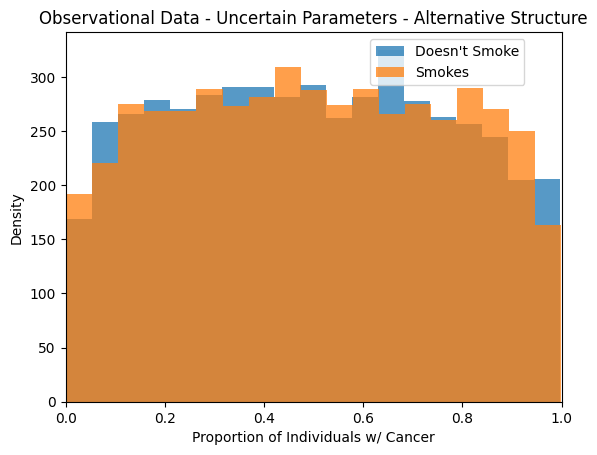

In [ ]:
predictions_alt_bayesian = multiple_samples(
    alt_bayesian_population_causal_model, (n_individuals,)
)
visualize_proportions_multiple(
    predictions_alt_bayesian,
    "Observational Data - Uncertain Parameters - Alternative Structure",
)

Just from looking at observational samples obtained using this alternative structure, we do not see anything obviously different from the causal model we've used so far. However, differences will arise when we inspect interventional distributions over random variables. In our new alternative candidate model, smoking has no effect on cancer whatsoever, and thus we shouldn't ever see any difference between cancer rates between individuals when individuals are forced to smoke or not smoke.

To visualize this point, we can again apply an intervention to this new model and simulate from the transformed model. This time we'll implement the intervention even more succinctly by intervening on the `alt_bayesian_causal_model` directly.

In [ ]:
def alt_bayesian_intervened_causal_model(n_individuals):
    smokes_assignment = torch.tensor([0.0, 1.0]).repeat(n_individuals // 2)
    transformed_model = do(
        alt_bayesian_population_causal_model, {"smokes": smokes_assignment}
    )
    return transformed_model(n_individuals)

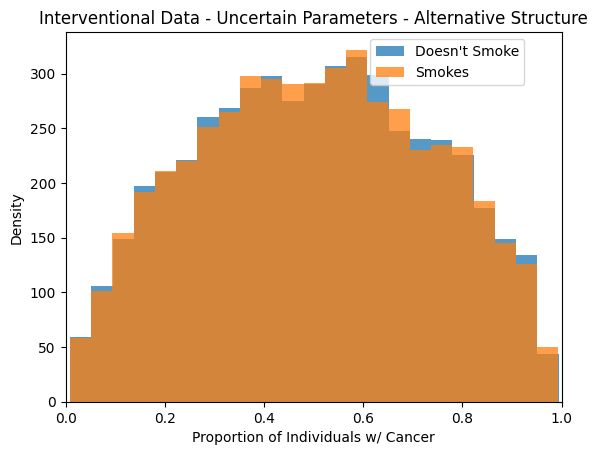

In [ ]:
predictions_alt_int_bayesian = multiple_samples(
    alt_bayesian_intervened_causal_model, (n_individuals,)
)
_ = visualize_proportions_multiple(
    predictions_alt_int_bayesian,
    "Interventional Data - Uncertain Parameters - Alternative Structure",
)

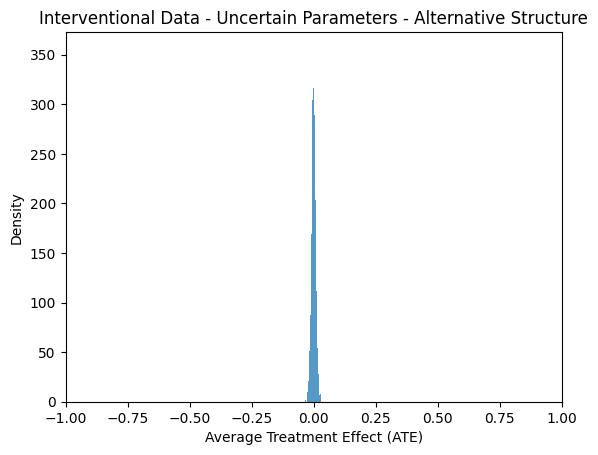

In [ ]:
_ = visualize_ATE(
    predictions_alt_int_bayesian,
    "Interventional Data - Uncertain Parameters - Alternative Structure",
)

While our uncertainty about the proportions of individuals with cancer is very wide, we now see that, as expected, we no longer see any association between smoking and cancer after applying an intervention under this alternative model. The resulting distribution of ATE estimates is now narrowly centered around 0. In other words, intervening on whether an individual smokes never impacts the probability of getting cancer under this model, regardless of the parameters.

Using our two probabilistic programs representing different plausible structures (and with uncertain parameters), we can write a probabilistic program that randomly chooses between them.  Conceptually, this represents a scenario in which we think that it is equally plausible that smoking causes cancer and that cancer causes smoking.

In [ ]:
def bayesian_population_causal_model_uncertain_structure(n_individuals):

    original_result = bayesian_population_causal_model(n_individuals)
    alt_result = alt_bayesian_population_causal_model(n_individuals)

    is_original_model = pyro.sample("is_original_model", Bernoulli(0.5)).bool()

    return {
        k: torch.where(is_original_model, original_result[k], alt_result[k])
        for k in original_result.keys()
    }

### Simulating Observational Data with Uncertain Structure and Parameters

Again, we can simulate from the observational distribution, this time using our model with uncertainty over both structure and parameters.

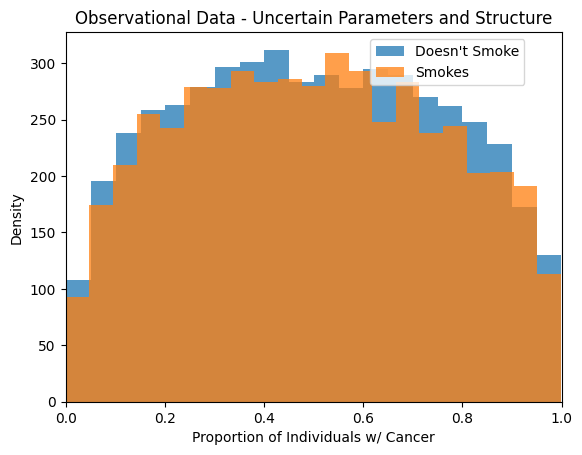

In [ ]:
predictions_uncertain_structure_bayesian = multiple_samples(
    bayesian_population_causal_model_uncertain_structure, (n_individuals,)
)
_ = visualize_proportions_multiple(
    predictions_uncertain_structure_bayesian,
    "Observational Data - Uncertain Parameters and Structure",
)

### Simulating Interventional Data with Uncertain Structure and Parameters

Earlier we showed that interventions in ChiRho compose freely with hierarchical Bayesian extensions of our original model with deterministic parameters. Perhaps not surprisingly, interventions are still well-behaved even when we included uncertainty over structures in our programs.

To see this, let's again apply our intervention and visualize the results of repeated samples from our model with structural uncertainty. As expected, we see that approximately half of the simulations from this model with structural uncertainty show a difference in cancer rate between smokers and non-smokers (representing samples in which `is_original_model=1`)


In [ ]:
def bayesian_intervened_causal_model_uncertain_structure(n_individuals):
    smokes_assignment = torch.tensor([0.0, 1.0]).repeat(n_individuals // 2)
    transformed_model = do(
        bayesian_population_causal_model_uncertain_structure,
        {"smokes": smokes_assignment},
    )
    return transformed_model(n_individuals)

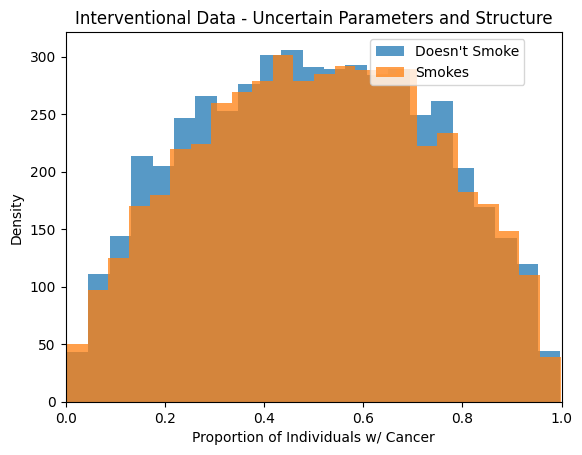

In [ ]:
predictions_uncertain_structure_int_bayesian = multiple_samples(
    bayesian_intervened_causal_model_uncertain_structure, (n_individuals,)
)
_ = visualize_proportions_multiple(
    predictions_uncertain_structure_int_bayesian,
    "Interventional Data - Uncertain Parameters and Structure",
)

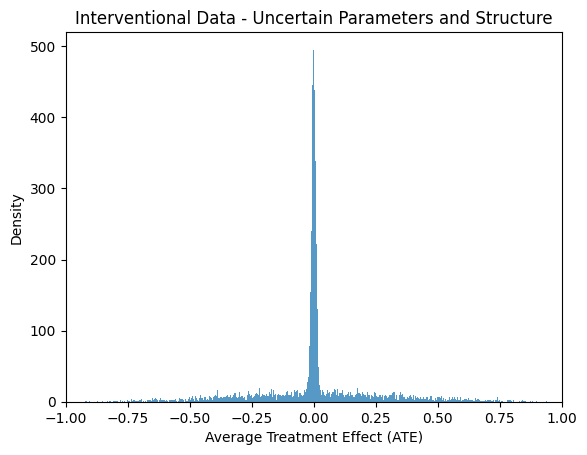

In [ ]:
_ = visualize_ATE(
    predictions_uncertain_structure_int_bayesian,
    "Interventional Data - Uncertain Parameters and Structure",
)

Now that we've incorporated uncertainty about the structure *and* parameters, we can see that samples from the post-intervention version of our program sometimes show an effect of smoking on cancer and sometimes show no effect. We this clearly with a sharp peak at $ATE=0$ above. In other words, our uncertainty over causal models naturally propagates to uncertainty over causal conclusions. We can visualize this flow of uncertainty in the following (again somewhat cartoonish) diagram showing how information flows from observational probabilistic programs to interventions probabilistic programs and subsequently to factual and counterfactual data.

![fig3](https://basisresearch.github.io/chirho/_images/Interventional_Marginal.png)

## Problem 7:

Create a variation of the extended model that changes one of the causal assumptions. For example, you could create a model that breaks the dependency between age and stress, or assumes that stress decreases with age instead of increasing. Follow the example above to combine your original and variant models to represent uncertainty between them and visualize the ATE for the combined model.

In [ ]:
# Implement me!

## Observation 3: causal inference is probabilistic inference


So far we've seen how introducing intervention program transformations using ChiRho's `do` makes it straightforward to reason about the causal implications of (i) uncertainty over the strength of causal effects and (ii) uncertainty over causal structure. We can call this progress *causal modeling*. In practice however, we often don't want to just posit causal knowledge about the world, we also want to update that knowledge in light of observational and experimental data. We'll call this process of learning about cause and effect from data *causal inference*. The key insight underlying ChiRho is that once we have a Bayesian causal model representing our uncertainty about cause-effect relationships, causal inference simply reduces to probabilistic inference in what's known as a *multi-world* transformation of our original causal model.

As we'll show in this section, to reduce causal inference to probabilistic inference using ChiRho we have to follow a few steps:
1. Transform our ChiRho program into a new Pyro program that represents a joint distribution over both outcomes, i.e. what actually happened, and counterfactual outcomes, i.e. what would have happened had we intervened. We'll call this a *multi-world program*.
2. Condition the factual outcomes in our multi-world program according to some observed data.
3. Run (approximate) posterior inference in the conditioned multi-world program, resulting in an updated distribution over both parameters and counterfactual outcomes.

**Important Note:** Readers familiar with causal inference may find the statement that "causal inference reduces to probabilistic inference" unpalatable. To clarify, we are not claiming that causal inference reduces to probabilistic inference *absent any assumptions*. Instead, we simply propose that users encode their causal assumptions as probabilistic programs.

### Automatically Constructing Counterfactual Worlds - `MultiWorldCounterfactual`

To make this concrete, we need to use another program transformation provided by ChiRho, the `MultiWorldCounterfactual` effect handler. Intuitively, this new effect handler tells ChiRho that any `pyro.sample` statements that are downstream of an intervention should be sampled multiple times, once for the observable world without interventions and once for each counterfactual world with interventions applied. Then, we can access and manipulate data in these counterfactual worlds using ChiRho's named tensor indexing utilities, `gather`, `IndexSet`, and `indices_of`.

Note: For a more advanced use-case of the `MultiWorldCounterfactual` effect handler, see our [Mediation Analysis](https://basisresearch.github.io/chirho/mediation.html) notebook.

In [ ]:
def bayesian_population_counterfactual_model(n_individuals):
    with MultiWorldCounterfactual() as context:
        return bayesian_population_intervened_causal_model(n_individuals), context


results, counterfactual_context = bayesian_population_counterfactual_model(n_individuals)

with counterfactual_context:
    # ChiRho's `MultiWorldCounterfactual` effect handler automatically constructs named index sites
    # corresponding to the names of all variables that were intervened upon using `do`.
    # Here, that is only `smokes`.
    print("Counterfactual indices --- ", indices_of(results["cancer"]))

    # `gather` extracts the subset of values corresponding to a particular counterfactual
    # world given by the specific `IndexSet`. Here, `smokes=0` refers to the counterfactual
    # world in which `smokes` was not intervened on.
    smokes_factual = gather(results["smokes"], IndexSet(smokes={0})).squeeze()
    smokes_counterfactual = gather(
        results["smokes"], IndexSet(smokes={1})
    ).squeeze()

    cancer_factual = gather(results["cancer"], IndexSet(smokes={0})).squeeze()
    cancer_counterfactual = gather(
        results["cancer"], IndexSet(smokes={1})
    ).squeeze()

print("smokes_factual --- ", smokes_factual)
print("smokes_counterfactual --- ", smokes_counterfactual)
print("cancer_factual --- ", cancer_factual)
print("cancer_counterfactual --- ", cancer_counterfactual)

Counterfactual indices ---  IndexSet({'smokes': {0, 1}})
smokes_factual ---  tensor([1., 1., 1.,  ..., 0., 1., 1.])
smokes_counterfactual ---  tensor([0., 1., 0.,  ..., 1., 0., 1.])
cancer_factual ---  tensor([1., 1., 1.,  ..., 1., 1., 1.])
cancer_counterfactual ---  tensor([1., 1., 1.,  ..., 1., 1., 1.])


Using somewhat light and informal mathematical notation, the tensors returned from the model transformed using the `MultiWorldCounterfactual` handler represent samples from the joint distribution $P(\mathit{stress}, \mathit{smokes}, \mathit{cancer}, \mathit{stress}_{cf}, \mathit{smokes}_{cf}, \mathit{cancer}_{cf})$, where $\mathit{stress}$, $\mathit{smokes}$, and $\mathit{cancer}$ are the random variables representing individual attributes without an intervention and $\mathit{stress}_{cf}$, $\mathit{smokes}_{cf}$, and $\mathit{cancer}_{cf}$ are the random variables representing individual attributes after applying our intervention.

However, as we mentioned before, causal inference is about coming to causal conclusions combining modeling assumptions *and* data, not just modeling assumptions alone. Now that we have a model representing a joint distribution over both observational and interventional data, we can condition our model and apply approximate inference techniques just as we would any other Pyro model. For example, using Pyro's support for stochastic variational inference we can obtain an approximate conditional distribution $P(\mathit{stress}_{cf}, \mathit{smokes}_{cf}, \mathit{cancer}_{cf}~|~\mathit{stress}, \mathit{smokes}, \mathit{cancer})$. To see how ChiRho enables causal inference, let's first generate some synthetic observational data for $\mathit{stress}$, $\mathit{smokes}$, and $\mathit{cancer}$ in which approximately half of the individuals smoke, and those who do are more likely to have cancer than those who don't.

### Generating Synthetic Data

In [ ]:
data_stress_prob = torch.tensor([0.5])
data_smokes_cond_prob = torch.tensor([0.3, 0.6])
data_cancer_cond_prob = torch.tensor([[0.1, 0.3], [0.1, 0.9]])

data = population_causal_model(
    n_individuals,
    causal_model,
    data_stress_prob,
    data_smokes_cond_prob,
    data_cancer_cond_prob,
)

### Conditioning the Causal Model on Observational Data

Now that we have synthetic data, we can condition on it inside of the `MultiWorldCounterfactual` handler we saw earlier. This creates a new model `counterfactual_model_conditioned`, that represents the conditional distribution we're interested in, $P(\mathit{stress}_{cf}, \mathit{smokes}_{cf}, \mathit{cancer}_{cf}~|~\mathit{stress}, \mathit{smokes}, \mathit{cancer})$.

In [ ]:
counterfactual_model_conditioned = condition(bayesian_population_counterfactual_model, data)

counterfactual_conditioned_results, counterfactual_conditioned_context = counterfactual_model_conditioned(
    n_individuals
)

with counterfactual_conditioned_context:
    # ChiRho's `condition` only conditions the model on the observational part
    # of the model, not the counterfactual part.
    assert torch.allclose(
        gather(counterfactual_conditioned_results["smokes"], IndexSet(smokes={0})).squeeze(),
        data["smokes"],
    )
    assert not torch.allclose(
        gather(counterfactual_conditioned_results["smokes"], IndexSet(smokes={1})).squeeze(),
        data["smokes"],
    )
    assert torch.allclose(
        gather(counterfactual_conditioned_results["cancer"], IndexSet(smokes={0})).squeeze(),
        data["cancer"],
    )
    assert not torch.allclose(
        gather(counterfactual_conditioned_results["cancer"], IndexSet(smokes={1})).squeeze(),
        data["cancer"],
    )

### Using Variational Inference for Bayesian Causal Inference

After using the `MultiWorldCounterfactual` and the `do` handlers, the resulting model can be treated as an ordinary Pyro program. Just as in Pyro, conditioning a model on data means that we can no longer sample directly from the `counterfactual_model_conditioned` model by just running the program; instead we need to run an *approximate inference algorithm*.

Because we've used ChiRho's program transformations to construct an ordinary Pyro program, we can use Pyro's built-in support for approximate inference. To see this, let's run stochastic variational inference with a reparameterized Gaussian mean-field variational approximation.

In [ ]:
num_iterations = 1000 if not smoke_test else 10

adam = pyro.optim.Adam({"lr": 0.03})
elbo = pyro.infer.Trace_ELBO()

guide = AutoNormal(
    block(
        counterfactual_model_conditioned,
        expose=["stress_prob", "smokes_cond_prob", "cancer_cond_prob"],
    )
)

svi = SVI(counterfactual_model_conditioned, guide, adam, loss=elbo)

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(n_individuals)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / n_individuals))

[iteration 0001] loss: 2.7313
[iteration 0101] loss: 2.1594
[iteration 0201] loss: 2.1144
[iteration 0301] loss: 2.1249
[iteration 0401] loss: 2.1195
[iteration 0501] loss: 2.1140
[iteration 0601] loss: 2.1174
[iteration 0701] loss: 2.1222
[iteration 0801] loss: 2.1308
[iteration 0901] loss: 2.1246


### Simulating Interventional Data from the Approximate Posterior

We can visualize the resulting posterior distribution over intervened models just as we did before with data drawn from the prior.

In [ ]:
predictive_counterfactual_posterior = pyro.infer.Predictive(
    bayesian_population_counterfactual_model, guide=guide, num_samples=num_samples
)
predictions_counterfactual_posterior = predictive_counterfactual_posterior(n_individuals)

with counterfactual_conditioned_context:
    predictions_int_posterior = {
        k: gather(predictions_counterfactual_posterior[k], IndexSet(smokes={1})).squeeze()
        for k in predictions_counterfactual_posterior.keys()
    }

# This intervention assignment is not stored in the trace, so we need to manually assign it.
predictions_int_posterior["smokes"] = smokes_counterfactual

In [ ]:
predictions_int_truth = multiple_samples(
    population_intervened_causal_model,
    (
        causal_model,
        n_individuals,
        data_stress_prob,
        data_smokes_cond_prob,
        data_cancer_cond_prob,
    ),
)

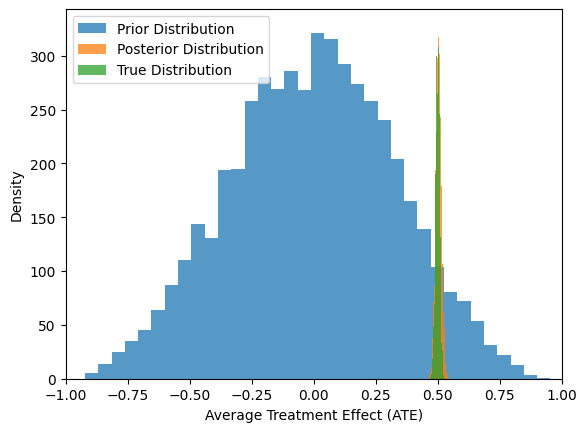

In [ ]:
ax = visualize_ATE(predictions_int_bayesian, label="Prior Distribution")
visualize_ATE(predictions_int_posterior, label="Posterior Distribution", ax=ax)
visualize_ATE(predictions_int_truth, label="True Distribution", ax=ax)
ax.legend()
plt.show()

Using our conceptual diagrams from before, we can see how data informs our updated belief about causal models, which then propagate forward into counterfactual outcomes and causal conclusions. Even though we've only observed data in a world where people choose whether to smoke or not of their own free will, this observed data tells us something about which causal models are plausible. Importantly, this process of mapping data in one world to conclusions in another (e.g. a world in which people are randomly assigned smoking behavior), requires assumptions. When using ChiRho, the models we write encode those assumptions implicitly by how interventions transform them. In subsequent tutorials we'll discuss this subtlety and consideration in more detail. For now, remember that this ability to reduce causal inference to probabilistic inference doesn't come out of thin air.

![fig4](https://basisresearch.github.io/chirho/_images/Interventional_Posterior.png)

## Problem 8:

Run the analysis above on your extended model. Is the effect of smoking on cancer lower or higher in the model that adds age as a covariate?

In [ ]:
# Implement me!

## Recap

Before we conclude this tutorial, let's first recap, and then zoom out thinking a bit more broadly about what it is that we illustrated.

**Observation 1**

1. We wrote a causal model using the Pyro probabilistic programming language relating $stress$, $smokes$ and $cancer$, defined as a function of known parameters, and showed how this model can be used to simulate observations for a population of individuals using Pyro's `plate` effect handler.
2. We wrote a modified version of our causal model in which individuals are "forced" to smoke or not smoke, modifying the original mechanism that determines whether individuals choose to smoke or not.
3. We showed how this program rewriting can be automated with ChiRho using the `do` program transformation.

**Observation 2**

4. Using our causal model defined as a function of known parameters we wrote a Bayesian hierarchical causal model relating $stress$, $smokes$, and $cancer$. We showed how this Bayesian extension induces a distribution over populations of individuals, and the observational relationships between $smokes$ and $cancer$.
5. We applied ChiRho's `do` program transformation to the Bayesian hierarchical causal model, and showed how this induces a distribution over the attributes of individuals who are forced to smoke or not smoke.
6. We wrote an alternative Bayesian hierarchical causal model in which cancer causes individuals to smoke, rather than vice-versa as in our original model. Similar to our original model, this alternative model induced broad uncertainty over the observational relationship between $smokes$ and $cancer$. However, unlike our original model, forcing individuals smoke induced no change in whether individuals got cancer.
7. We wrote a Bayesian hierarchical causal model with uncertainty over parameters and structure, implemented by randomly choosing between our two candidate causal models based on the outcome of a latent discrete random variable. We showed that this model induced a distribution over average treatment effects that had a sharp peak at $ATE=0$.

**Observation 3**

8. We showed how to represent a joint distribution over both observational and interventional distributions using ChiRho's `MultiWorldCounterfactual` effect handler.
9. Conditioning our model on (synthetic) observed data, we showed how causal inference problems can be solved using Pyro's extensive support for approximate variational inference.
10. Finally, we showed how the posterior distribution over causal models induced a posterior distribution over the attributes of individuals who forced to smoke or not smoke, conditional on observations of individuals who chose to smoke according to the original mechanisms.

## A Causal Bayesian Workflow

To conclude this tutorial, let's think about how to use ChiRho for causal inference problems more broadly. We elaborate on how the program transformation-based operations we've demonstrated so far fit into the standard statistical practice embodied by Peterson and van der Laans' *Causal Roadmap* \[Petersen et al. 2014\]. Here, we show the original causal roadmap components in **bold**, and how we would express them in terms of ChiRho in *italics*.


1. **Specify knowledge about the system to be studied using a causal model**. *This knowledge should be expressed by the ordering and functional/distributional relationships of random variables in a Pyro program*.
2. **Specify the observed data and their link to the causal model.** *Express the relationships between observations and the causal model by (optionally) adding additional model components representing mechanisms for missing data, and by conditioning the original Pyro program on observations*.
3. **Specify a target causal quantity.** *Express the target causal quantity as a combination of program transformations including world-splitting (e.g. `MultiWorldCounterfactual`), intervention (`do`), and probabilistic conditioning (`condition`).*
4. **Assess identifiability.** *Currently ChiRho does not support automated methods for assessing identifiability. Future versions will implement non-parametric methods such as the do-calculus \[Pearl 2009\], or numerical approaches such as Simulation-based identifiability \[Witty et al. 2022\].*
5. **State the statistical estimation problem**. *ChiRho does not currently distinguish between causal estimation and statistical estimation. Therefore, this component of the original causal roadmap is not covered by ChiRho. In future versions we may implement nonparametric causal inference utilities using free variables, in which case causal reasoning (such as nonparametric identifiability analysis) and statistical estimation may occur over different models for the same process.*
6. **Estimate.** *Use Pyro's approximate inference capabilities (e.g. SVI) to estimate the posterior distributions over counterfactual variables of interest.*
7. **Interpret.** *ChiRho does not currently provide any support for interpreting the validity of causal assumptions or conclusions.*

Importantly, once we arrive at step 6, we can again dispatch the standard non-causal *Bayesian Workflow* \[Gelman et al. 2020\] for assessing the validity of probabilistic modeling and inference. Note: while the causal roadmap and the Bayesian workflow are mostly orthogonal, there are some special considerations that can be made to make model criticism more effective in a causal inference setting \[Tran et al. 2016\].

## References

Aldrich, John. “Autonomy.” Oxford Economic Papers 41, no. 1 (1989): 15–34.

Gelman, Andrew, et al. "Bayesian workflow." arXiv preprint arXiv:2011.01808 (2020).

Pearl, Judea. Causality: Models, Reasoning and Inference. 2nd ed. USA: Cambridge University Press, 2009.

Petersen, Maya L., and Mark J. van der Laan. "Causal models and learning from data: integrating causal modeling and statistical estimation." Epidemiology (Cambridge, Mass.) 25.3 (2014): 418.

Tran, Dustin, et al. "Model criticism for bayesian causal inference." arXiv preprint arXiv:1610.09037 (2016).

Witty, Sam. "Bayesian Structural Causal Inference with Probabilistic Programming" Doctoral Dissertation (2023).

Witty, Sam, David Jensen, and Vikash Mansinghka. "SBI: A Simulation-Based Test of Identifiability for Bayesian Causal Inference." arXiv preprint arXiv:2102.11761 (2021).